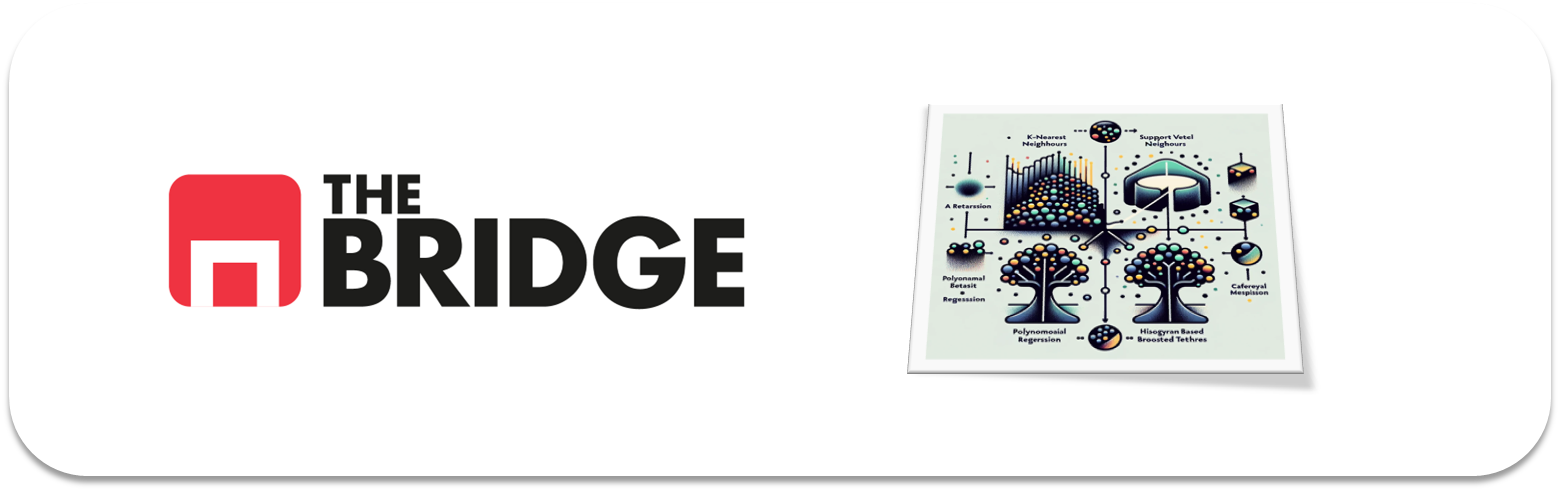

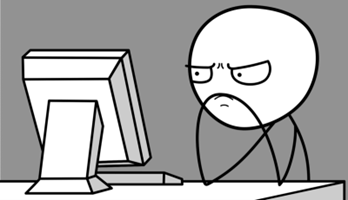

Para hacer un **repaso a los problemas de regresión con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Evaluación contra test.  
10. Análisis de errores, posibles acciones futuras.  
11. EXTRA: Persistencia del modelo en disco.  

### El problema de Negocio

El ayuntamiento de Freehold, Nueva Jersey, está preocupado por los ***niveles de Ozono en situaciones de contaminación***. Ha adquirido unos sensores muy potentes que permiten medir la composición de la calidad del aire casi en tiempo real, pero desgraciadamente la medida de Ozono se obtiene mucho más tarde (casi 12 horas después, este dato de las horas no es relevante para el problema). Las medidas son enviadas a una plataforma central donde se quiere incorporar un ***modelo que en función de esas medidas pueda predecir el nivel de $O_3$ (Ozono) en el aire*** y establecer alarmas y umbrales para avisar a la población o tomar medidas si es necesaria.

El concejal de urbanismo y tecnología, Bruce S., os contrata para que creéis ese modelo y para ello os suministra un dataset con medidas de la calidad de aire donde han incorporado el nivel de Ozono ("PT08.S5(O3)") posteriormente. Quieren un ***modelo que se equivoque en media en menos de 100 unidades por millón (la medida en la que tienen registrada la presencia de Ozono)***.

¡Manos a la obra!

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [129]:
import pandas as pd
import numpy as np

#pintar
import matplotlib.pyplot as plt
import seaborn as sns

### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

Métricas que penalicen bien los errores y ayuden a comparar modelos.

✅ MAE → Principal, ya que la restricción del problema es que el error medio sea menor a 100.

✅ RMSE → Complementaria, para ver si hay errores grandes que impacten el modelo.ç

✅ R² → Referencia, para evaluar qué tanto explica el modelo la variabilidad de los datos.

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [130]:
data = pd.read_csv('./data/air_contamination.csv')
data.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8991 entries, 0 to 8990
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         8991 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   NMHC(GT)       8991 non-null   int64  
 3   C6H6(GT)       8991 non-null   float64
 4   PT08.S2(NMHC)  8991 non-null   float64
 5   NOx(GT)        8991 non-null   float64
 6   PT08.S3(NOx)   8991 non-null   float64
 7   NO2(GT)        8991 non-null   float64
 8   PT08.S4(NO2)   8991 non-null   float64
 9   PT08.S5(O3)    8991 non-null   float64
 10  T              8991 non-null   float64
 11  RH             8991 non-null   float64
 12  AH             8991 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 913.3 KB


##### 📌 **Descripción de las Variables del Dataset**

El dataset contiene mediciones de la **calidad del aire**, incluyendo concentraciones de gases contaminantes y variables ambientales. La variable objetivo es **`PT08.S5(O3)`** (concentración de Ozono).

###### 📋 **Tabla de Variables**

| **Variable**       | **Descripción** |
|-------------------|------------------------------------------------|
| `CO(GT)`         | **Monóxido de Carbono (CO)** en el aire (mg/m³). |
| `PT08.S1(CO)`    | **Sensor 1** de medición de CO (resistencia eléctrica). |
| `NMHC(GT)`       | **Hidrocarburos no metánicos (NMHC)** en µg/m³. |
| `C6H6(GT)`       | **Benceno (C₆H₆)** en el aire (µg/m³). |
| `PT08.S2(NMHC)`  | **Sensor 2** de medición de NMHC. |
| `NOx(GT)`        | **Óxidos de Nitrógeno (NOx)** en ppb. |
| `PT08.S3(NOx)`   | **Sensor 3** de medición de NOx. |
| `NO2(GT)`        | **Dióxido de Nitrógeno (NO₂)** en ppb. |
| `PT08.S4(NO2)`   | **Sensor 4** de medición de NO₂. |
| `PT08.S5(O3)`    | **Ozono (O₃)** en el aire (ppb) → 🔥 **Variable Objetivo** 🔥. |
| `T`             | **Temperatura** en °C. |
| `RH`            | **Humedad Relativa (%)**. |
| `AH`            | **Humedad Absoluta (g/m³)**. |

---

##### 🔍 **Observaciones Iniciales**
- ✅ **Todas las variables son numéricas continuas**, facilitando la regresión.
- ✅ **Algunas variables pueden estar correlacionadas**:
  - `NOx(GT)` y `NO2(GT)` probablemente tengan una relación fuerte.
  - `T`, `RH` y `AH` podrían influir en `PT08.S5(O3)`.
- ✅ **La variable objetivo es `PT08.S5(O3)`**, que queremos predecir.


In [132]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CO(GT),8991.0,-34.897053,78.202259,-200.000000,0.600000,1.500000,2.600000,11.900000
PT08.S1(CO),8991.0,1099.707856,217.084571,647.250000,936.750000,1063.000000,1231.250000,2039.750000
NMHC(GT),8991.0,-158.702591,140.680200,-200.000000,-200.000000,-200.000000,-200.000000,1189.000000
C6H6(GT),8991.0,10.082993,7.449640,0.149048,4.436942,8.239851,13.988478,63.741476
PT08.S2(NMHC),8991.0,939.029205,266.829000,383.250000,734.375000,909.000000,1116.250000,2214.000000
NOx(GT),8991.0,163.732788,252.081877,-200.000000,49.000000,139.800000,280.000000,1479.000000
PT08.S3(NOx),8991.0,835.370973,256.815106,322.000000,657.875000,805.500000,969.250000,2682.750000
NO2(GT),8991.0,56.654087,126.902274,-200.000000,52.000000,96.000000,132.000000,332.600000
PT08.S4(NO2),8991.0,1456.143486,346.204540,551.000000,1226.625000,1462.750000,1673.500000,2775.000000
PT08.S5(O3),8991.0,1022.780725,398.480897,221.000000,731.375000,963.250000,1273.375000,2522.750000


### Ejercicio 3: Split

Haz el split en train y test.

In [133]:
from sklearn.model_selection import train_test_split

# División del dataset en 80% para entrenamietno y 20% de prueva
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Tamaños de los subconjuntos
print(f"✅ Tamaño de train_data: {train.shape}")
print(f"✅ Tamaño de test_data: {test.shape}")

✅ Tamaño de train_data: (7192, 13)
✅ Tamaño de test_data: (1799, 13)


### Ejercicio 4: MiniEDA (I)

Analiza la distribución del target brevemente.

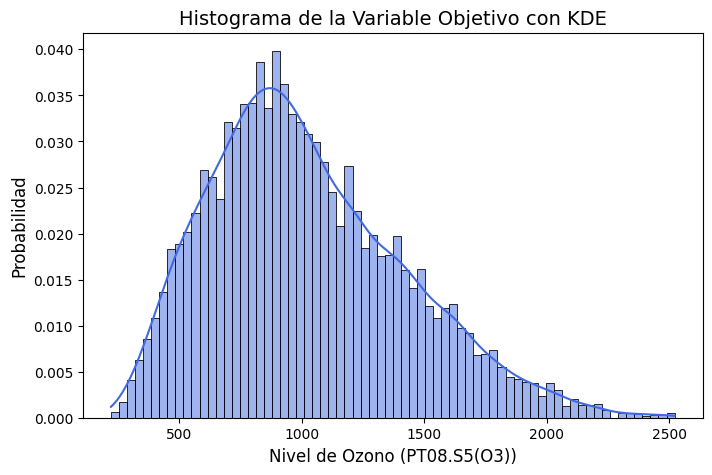

In [134]:
target = data['PT08.S5(O3)']

# Definir la variable objetivo
target = data['PT08.S5(O3)']

# Configurar el tamaño del gráfico
plt.figure(figsize=(8,5))

# Calcular el histograma normalizado para obtener la función de probabilidad
sns.histplot(target, kde=True, bins=70, stat="probability", color="royalblue", edgecolor="black")

# Agregar etiquetas y título
plt.xlabel("Nivel de Ozono (PT08.S5(O3))", fontsize=12)
plt.ylabel("Probabilidad", fontsize=12)
plt.title("Histograma de la Variable Objetivo con KDE", fontsize=14)

# Mostrar el gráfico
plt.show()

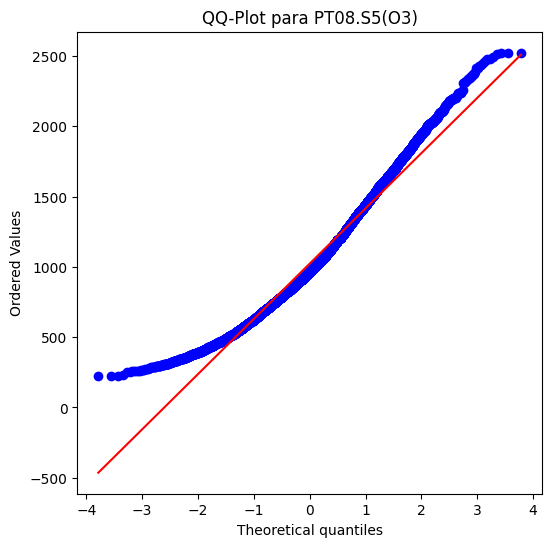

In [135]:
import scipy.stats as stats

# QQ-Plot para verificar normalidad
plt.figure(figsize=(6, 6))
stats.probplot(data['PT08.S5(O3)'], dist="norm", plot=plt)
plt.title("QQ-Plot para PT08.S5(O3)")
plt.show()

In [136]:
# Test de normalidad de la variable objetivo

from scipy.stats import shapiro, kstest, normaltest

# Shapiro-Wilk Test (Para menos de 5000 datos, más preciso)
shapiro_test = shapiro(target.sample(5000, random_state=42) if len(target) > 5000 else target)
print(f"📌 Test de Shapiro-Wilk: Estadístico={shapiro_test.statistic:.4f}, p-valor={shapiro_test.pvalue:.4f}")

# Kolmogorov-Smirnov Test (Para grandes muestras)
ks_test = kstest(target, 'norm', args=(target.mean(), target.std()))
print(f"📌 Test de Kolmogorov-Smirnov: Estadístico={ks_test.statistic:.4f}, p-valor={ks_test.pvalue:.4f}")

# D'Agostino-Pearson Test (Prueba general de normalidad)
dagostino_test = normaltest(target)
print(f"📌 Test de D'Agostino-Pearson: Estadístico={dagostino_test.statistic:.4f}, p-valor={dagostino_test.pvalue:.4f}")

# Si p-valor < 0.05 → Los datos NO son normales (rechazamos la hipótesis nula).


📌 Test de Shapiro-Wilk: Estadístico=0.9714, p-valor=0.0000
📌 Test de Kolmogorov-Smirnov: Estadístico=0.0611, p-valor=0.0000
📌 Test de D'Agostino-Pearson: Estadístico=504.2115, p-valor=0.0000


### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, para las numéricas analiza la correlación numéricamente y gráficamente, para las categóricas analiza la distribución del target para cada valor de la categórica.

In [137]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
CO(GT),7192.0,-35.402183,78.598763,-200.000000,0.600000,1.400000,2.500000,11.500000
PT08.S1(CO),7192.0,1096.742353,217.187012,647.250000,933.250000,1059.250000,1225.750000,2039.750000
NMHC(GT),7192.0,-160.296162,137.760344,-200.000000,-200.000000,-200.000000,-200.000000,1189.000000
C6H6(GT),7192.0,9.996265,7.413889,0.149048,4.372234,8.144817,13.806061,63.741476
PT08.S2(NMHC),7192.0,935.740255,266.308898,383.250000,730.937500,905.125000,1110.312500,2214.000000
NOx(GT),7192.0,162.499027,251.498158,-200.000000,47.000000,138.000000,280.000000,1389.000000
PT08.S3(NOx),7192.0,838.543254,258.474047,322.000000,661.250000,807.875000,974.000000,2682.750000
NO2(GT),7192.0,55.716838,126.820691,-200.000000,51.000000,95.000000,131.000000,321.600000
PT08.S4(NO2),7192.0,1454.166956,344.351668,551.000000,1226.687500,1462.250000,1668.250000,2775.000000
PT08.S5(O3),7192.0,1017.120643,397.817754,221.000000,725.187500,954.375000,1268.062500,2522.250000


array([[<Axes: title={'center': 'CO(GT)'}>,
        <Axes: title={'center': 'PT08.S1(CO)'}>,
        <Axes: title={'center': 'NMHC(GT)'}>,
        <Axes: title={'center': 'C6H6(GT)'}>],
       [<Axes: title={'center': 'PT08.S2(NMHC)'}>,
        <Axes: title={'center': 'NOx(GT)'}>,
        <Axes: title={'center': 'PT08.S3(NOx)'}>,
        <Axes: title={'center': 'NO2(GT)'}>],
       [<Axes: title={'center': 'PT08.S4(NO2)'}>,
        <Axes: title={'center': 'PT08.S5(O3)'}>,
        <Axes: title={'center': 'T'}>, <Axes: title={'center': 'RH'}>],
       [<Axes: title={'center': 'AH'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

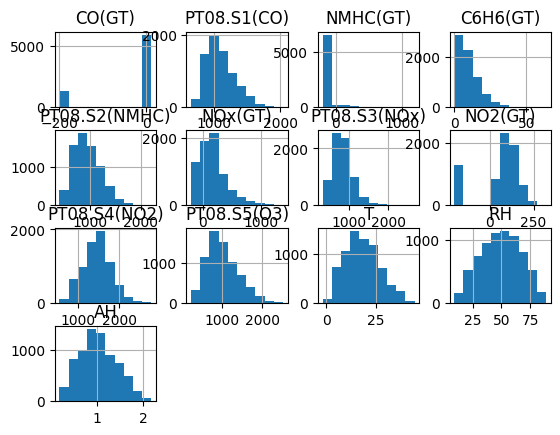

In [138]:
train.hist()

Correlaciones finales con la variable objetivo:
PT08.S5(O3)     1.000000
PT08.S3(NOx)    0.794185
NOx(GT)         0.623100
PT08.S4(NO2)    0.590688
NO2(GT)         0.337581
Name: PT08.S5(O3), dtype: float64


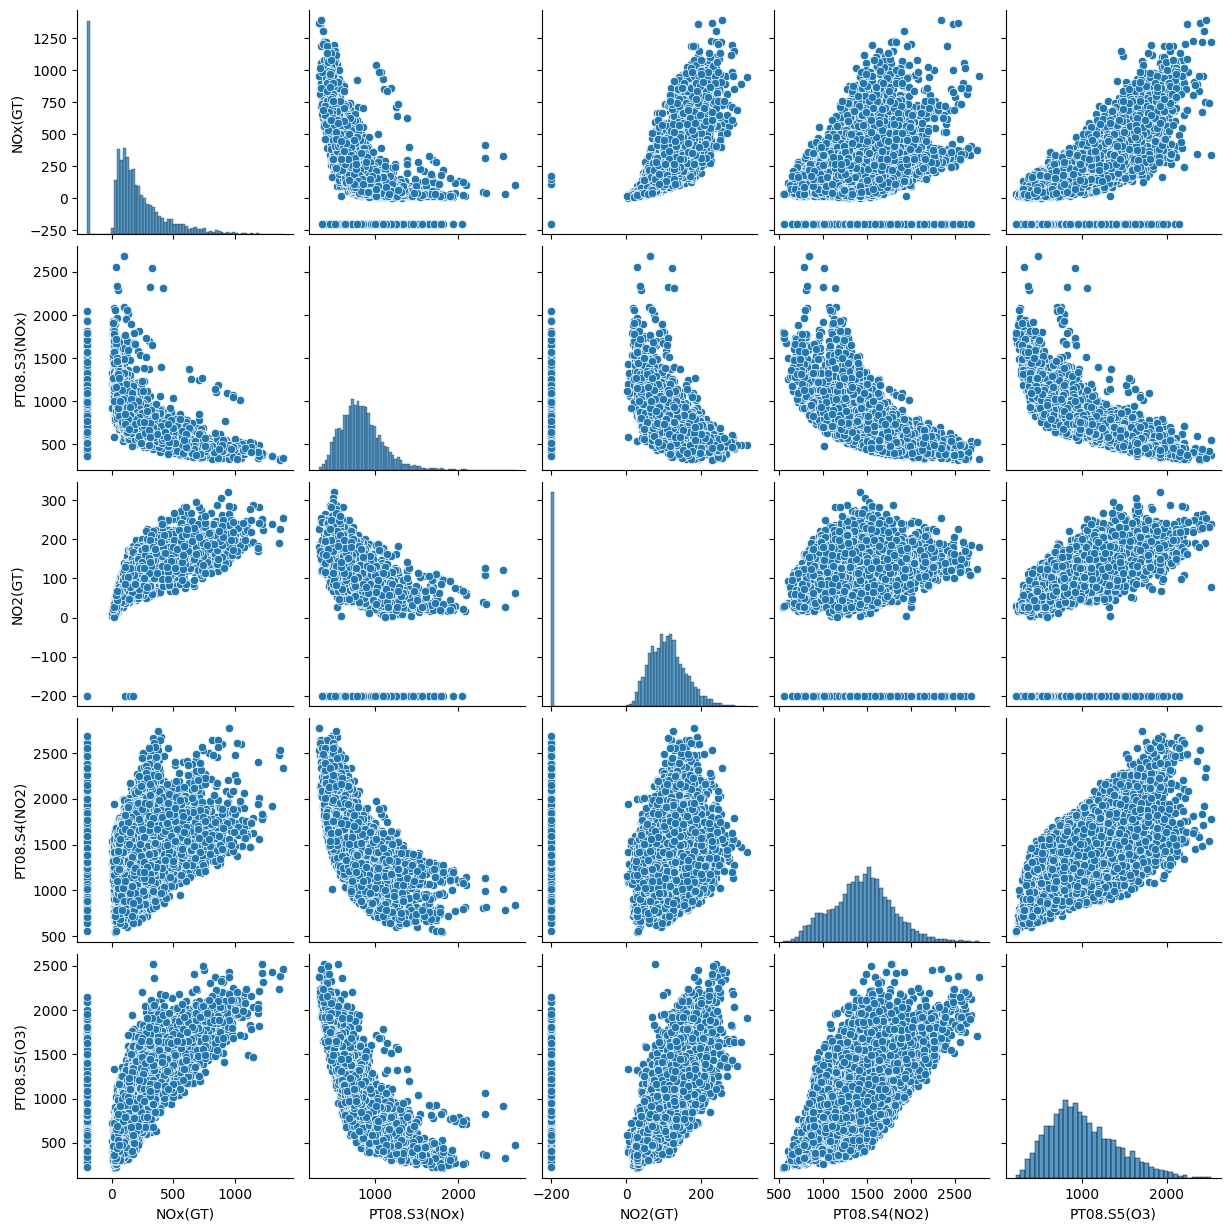

Variables seleccionadas: ['NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']


In [139]:
target = 'PT08.S5(O3)'

# 1. Calcular correlaciones con la variable objetivo
correlations = train.corr()[target].abs()
correlations

# Seleccionar variables con correlación > 0.7 con la variable objetivo
high_corr_features = correlations[correlations > 0.3].index.tolist()

high_corr_features

# Eliminar la variable objetivo de la lista (ya que aparece con correlación 1.0 consigo misma)
high_corr_features.remove(target)

high_corr_features


# 2. Filtrar variables altamente correlacionadas entre sí (> 0.7)
corr_matrix = train[high_corr_features].corr().abs()
selected_features = high_corr_features.copy()

for feature in high_corr_features:
    for other_feature in high_corr_features:
        if feature != other_feature and other_feature in selected_features:
            if corr_matrix.loc[feature, other_feature] > 0.85:
                selected_features.remove(other_feature)


# Agregar la variable objetivo a la lista seleccionada
selected_features.append(target)

# Calcular correlaciones finales con la variable objetivo
final_correlations = train[selected_features].corr()[target]
print("Correlaciones finales con la variable objetivo:")
print(final_correlations.abs().sort_values(ascending=False))

# 3. Visualizar con pairplot
sns.pairplot(train[selected_features])
plt.show()

# Imprimir las características seleccionadas
print("Variables seleccionadas:", selected_features)


In [140]:
selected_features.remove(target)


array([[<Axes: title={'center': 'NOx(GT)'}>,
        <Axes: title={'center': 'PT08.S3(NOx)'}>],
       [<Axes: title={'center': 'NO2(GT)'}>,
        <Axes: title={'center': 'PT08.S4(NO2)'}>]], dtype=object)

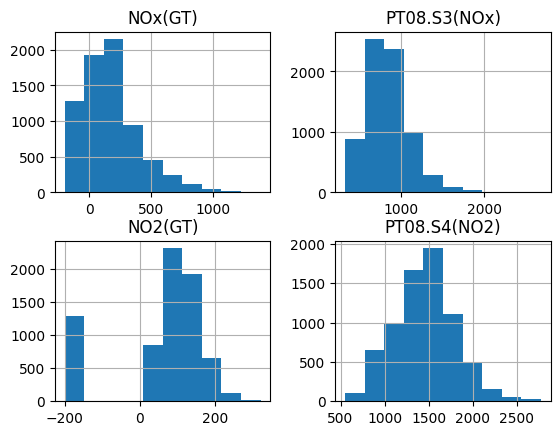

In [141]:
train[selected_features].hist()

### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

array([[<Axes: title={'center': 'NOx(GT)'}>,
        <Axes: title={'center': 'PT08.S3(NOx)'}>],
       [<Axes: title={'center': 'NO2(GT)'}>,
        <Axes: title={'center': 'PT08.S4(NO2)'}>]], dtype=object)

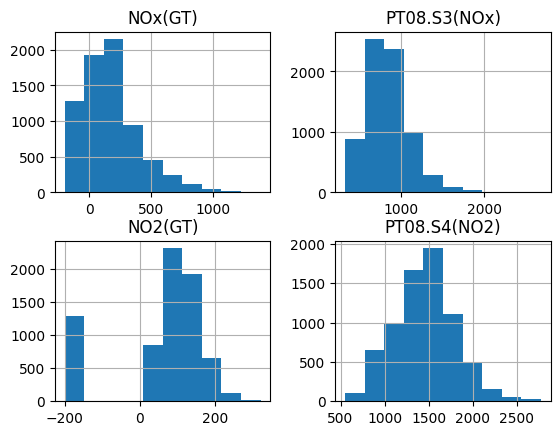

In [142]:
train[selected_features].hist()

### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

In [143]:
train

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
3846,-200.0,806.750000,-200,3.100426,658.25,-200.0,1113.250000,-200.0,1327.750000,428.25,32.350000,26.250000,1.252292
2088,2.5,998.000000,-200,14.065590,1118.75,207.0,831.750000,120.0,1779.750000,1056.75,31.574999,24.075000,1.099403
435,1.1,968.250000,75,3.280884,669.25,67.0,1261.000000,81.0,1245.500000,538.25,12.325000,46.799999,0.668597
4030,-200.0,924.500000,-200,4.707072,748.50,-200.0,825.750000,-200.0,1482.000000,738.50,23.525000,58.275000,1.667246
5991,1.9,1099.500000,-200,11.200577,1021.50,492.0,751.750000,193.0,1101.000000,1367.25,12.150000,30.050000,0.424485
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,4.6,1277.000000,-200,21.395706,1334.75,586.0,550.750000,182.0,1636.000000,1330.75,9.975000,71.499998,0.876824
5191,-200.0,974.250000,-200,7.049952,859.00,-200.0,772.250000,-200.0,1382.750000,954.00,15.225000,73.125000,1.256973
5390,3.2,1213.666667,-200,16.769009,1203.00,445.0,580.333333,129.0,1738.666667,1308.00,20.700000,58.600000,1.414201
860,5.7,1593.250000,743,22.999124,1377.50,309.0,581.750000,142.0,2158.750000,1448.50,14.625000,75.975000,1.257307


In [144]:
test

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
1153,1.4,1145.75,156,8.587110,923.00,79.0,845.00,96.0,1574.75,1165.75,19.575,49.800000,1.122057
8659,6.4,1609.00,-200,29.707874,1544.00,669.2,367.00,231.7,1999.00,1877.75,18.625,46.425001,0.986666
5212,-200.0,1117.50,-200,9.286931,950.50,-200.0,674.50,-200.0,1508.75,1124.25,19.400,70.100000,1.562583
7708,1.0,907.25,-200,2.415395,613.75,149.8,1052.00,119.8,781.75,627.00,5.100,37.900001,0.335822
4537,1.5,1040.00,-200,8.099001,903.25,145.0,781.75,92.0,1494.25,950.75,23.025,55.750000,1.548049
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5899,7.8,1659.00,-200,35.940155,1684.75,1290.0,422.75,272.0,1945.50,2155.00,15.975,41.525000,0.748316
2478,2.6,1138.25,-200,14.759833,1141.00,199.0,671.00,104.0,1926.50,1196.75,21.500,51.825000,1.312881
5028,-200.0,997.75,-200,9.029748,940.50,-200.0,784.50,-200.0,1442.00,913.75,18.150,55.950000,1.154710
5964,2.9,1086.50,-200,17.111654,1213.25,661.0,667.75,243.0,1215.50,1401.50,11.900,27.925000,0.388151


In [145]:
selected_features

['NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)']

In [146]:
X_train = train[selected_features].copy()
X_train
X_test = test[selected_features].copy()
X_test

# Eliminar outliers en la variable NO2(GT)
X_train = X_train[X_train['NO2(GT)'] > 0]
X_test = X_test[X_test['NO2(GT)'] > 0]

# Tranformación log de las variables
X_train[['NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)']] = X_train[['NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)']].apply(np.log)
X_test[['NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)']] = X_test[['NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)']].apply(np.log)

array([[<Axes: title={'center': 'NOx(GT)'}>,
        <Axes: title={'center': 'PT08.S3(NOx)'}>],
       [<Axes: title={'center': 'NO2(GT)'}>,
        <Axes: title={'center': 'PT08.S4(NO2)'}>]], dtype=object)

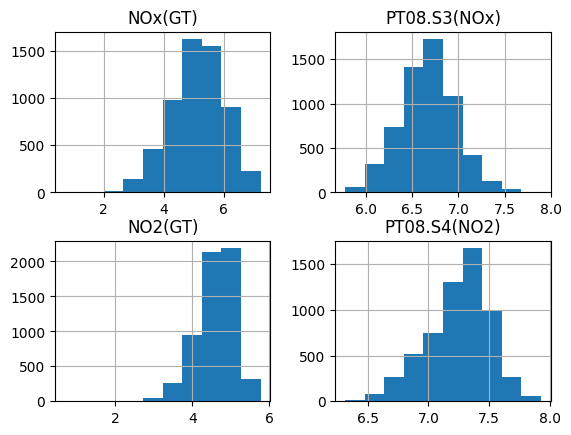

In [147]:
X_train.hist()

In [149]:
# Escalado con Standard Scaler
from sklearn.preprocessing import StandardScaler
# Aplicar StandardScaler a todas las features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [151]:
X_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
NOx(GT),5906.0,2.321956e-16,1.000085,-5.006345,-0.640639,0.049313,0.724155,2.372670
PT08.S3(NOx),5906.0,8.517851e-16,1.000085,-2.986717,-0.646211,0.015641,0.642643,4.065817
NO2(GT),5906.0,-9.720937e-16,1.000085,-8.053055,-0.573556,0.158476,0.682578,2.392625
PT08.S4(NO2),5906.0,2.764091e-15,1.000085,-3.665575,-0.593355,0.147005,0.696588,2.665803


### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [159]:
y_train = train['PT08.S5(O3)']
y_test = test['PT08.S5(O3)']

# Asegurar que y_train e y_test tengan los mismos índices que X_train_scaled y X_test_scaled
y_train = y_train.loc[X_train_scaled.index]
y_test = y_test.loc[X_test_scaled.index]

In [164]:
y_train.shape

(5906,)

### Ejercicios 9:

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. 

In [165]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Instanciar los modelos
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}


### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea "mean_absolute_error" (recuerda el funcionamiento del scoring en "sklearn", no te valdrá poner "mean_absolute_error"). Escoge el modelo ganador.

In [166]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, make_scorer

# Definir validación cruzada con k=5
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Evaluación de modelos con validación cruzada
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring=scoring)
    cv_results[name] = scores
    print(f"{name}: Mean MAE = {-np.mean(scores):.4f}, Std = {np.std(scores):.4f}")

Linear Regression: Mean MAE = 138.7902, Std = 2.6068
Random Forest: Mean MAE = 109.3316, Std = 1.2397
Support Vector Regressor: Mean MAE = 174.7084, Std = 3.2894
K-Nearest Neighbors: Mean MAE = 110.2644, Std = 0.7853
Gradient Boosting: Mean MAE = 114.9271, Std = 2.4027


### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "mean absolute error". 

In [171]:
from sklearn.model_selection import GridSearchCV

# Definir el modelo y los hiperparámetros para optimización con GridSearch
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Realizar GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, cv=kf, scoring=scoring, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Imprimir los mejores parámetros y la mejor puntuación
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor MAE:", -grid_search.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Mejor MAE: 109.0421506170911


### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

In [172]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
# Evaluación del mejor modelo en el conjunto de test
best_rf = grid_search.best_estimator_
y_pred_test = best_rf.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_r2 = r2_score(y_test, y_pred_test)

print("MAE en test set:", test_mae)
print("RMSE en test set:", test_rmse)
print("R² en test set:", test_r2)

MAE en test set: 109.86872811107861
RMSE en test set: 148.4503512104689
R² en test set: 0.8664053694981035


c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Ejercicio 13: Análisis de errores

Comparar los valores predichos contra los reales mediante una gráfica (puedes emplear la función que empleamos en el workout de la unidad anterior). Haz un pequeño análisis.

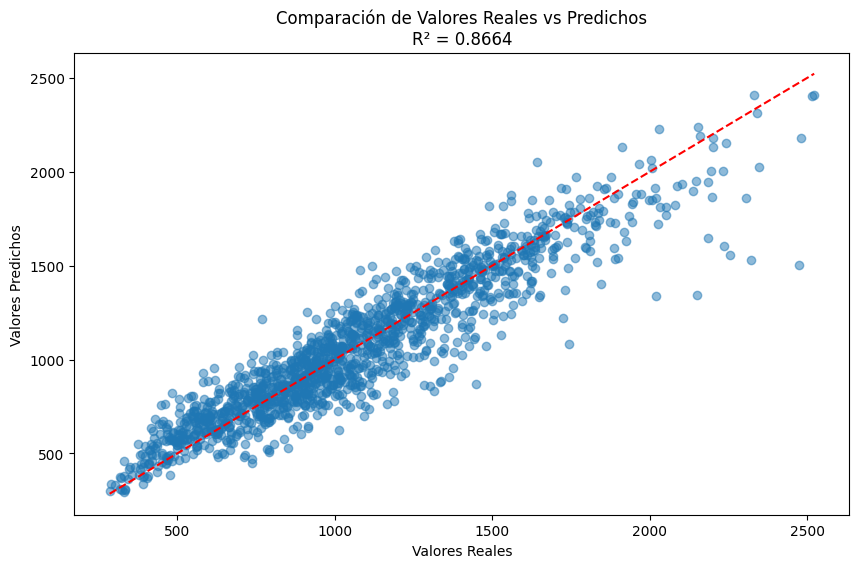

In [174]:
# Comparación de valores reales vs predichos con R² en el gráfico
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title(f"Comparación de Valores Reales vs Predichos\nR² = {test_r2:.4f}")
plt.show()

### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/o3_pred" con la extesión apropiada.